In [16]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.wrappers import LdaMallet

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim 
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [17]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [18]:
df=pd.read_csv('got_scripts_breakdown.csv', sep=';')
df.head()

,Column1,Season,Episode,Sentence,Name,N_serie,N_Season,Emision Date
0,1,Season 1,winter is coming,What d’you expect? They’re savages One lot ste...,waymar royce,1,1,17/04/2011
1,2,Season 1,winter is coming,I’ve never seen wildlings do a thing like this...,will,1,1,17/04/2011
2,3,Season 1,winter is coming,How close did you get?,waymar royce,1,1,17/04/2011
3,4,Season 1,winter is coming,Close as any man would,will,1,1,17/04/2011
4,5,Season 1,winter is coming,We should head back to the wall,gared,1,1,17/04/2011


In [19]:
# Convert to list
data = df.Sentence.values.tolist()

In [20]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['what', 'you', 'expect', 'they', 're', 'savages', 'one', 'lot', 'steals', 'goat', 'from', 'another', 'lot', 'and', 'before', 'you', 'know', 'it', 'they', 're', 'ripping', 'each', 'other', 'to', 'pieces']]


In [21]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['what', 'you', 'expect', 'they', 're', 'savages', 'one', 'lot', 'steals', 'goat', 'from', 'another', 'lot', 'and', 'before', 'you', 'know', 'it', 'they', 're', 'ripping', 'each_other', 'to', 'pieces']


In [22]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [23]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['expect', 'savage', 'lot', 'steal', 'goat', 'lot', 'know', 'rip', 'piece']]


In [24]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1)]]


In [10]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('expect', 1),
  ('goat', 1),
  ('know', 1),
  ('lot', 2),
  ('piece', 1),
  ('rip', 1),
  ('savage', 1),
  ('steal', 1)]]

In [51]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           eta =10,
                                           per_word_topics=True)

In [52]:
# Print the Keyword in the 20 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.000*"bash" + 0.000*"mero" + 0.000*"convinced" + 0.000*"entertainment" + '
  '0.000*"appreciation" + 0.000*"countless" + 0.000*"yap" + 0.000*"collect" + '
  '0.000*"titan" + 0.000*"pauper"'),
 (1,
  '0.000*"bash" + 0.000*"mero" + 0.000*"convinced" + 0.000*"entertainment" + '
  '0.000*"appreciation" + 0.000*"countless" + 0.000*"yap" + 0.000*"collect" + '
  '0.000*"titan" + 0.000*"pauper"'),
 (2,
  '0.000*"bash" + 0.000*"mero" + 0.000*"convinced" + 0.000*"entertainment" + '
  '0.000*"appreciation" + 0.000*"countless" + 0.000*"yap" + 0.000*"collect" + '
  '0.000*"titan" + 0.000*"pauper"'),
 (3,
  '0.000*"bash" + 0.000*"mero" + 0.000*"convinced" + 0.000*"entertainment" + '
  '0.000*"appreciation" + 0.000*"countless" + 0.000*"yap" + 0.000*"collect" + '
  '0.000*"titan" + 0.000*"pauper"'),
 (4,
  '0.000*"bash" + 0.000*"mero" + 0.000*"convinced" + 0.000*"entertainment" + '
  '0.000*"appreciation" + 0.000*"countless" + 0.000*"yap" + 0.000*"collect" + '
  '0.000*"titan" + 0.000*"pauper

In [53]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.578037494869359

Coherence Score:  0.5437313382396713


In [54]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


TypeError: Object of type complex is not JSON serializable

PreparedData(topic_coordinates=                                x        y  topics  cluster       Freq
topic                                                                 
9        (0.16494003385305403+0j)       0j       1        1  99.922005
7       (-0.00868105441331865+0j)       0j       2        1   0.006701
17     (-0.008681054413318652+0j)       0j       3        1   0.006395
0      (-0.008681054413318652+0j)       0j       4        1   0.005537
10     (-0.008681054413318652+0j)       0j       5        1   0.005143
18      (-0.00868105441331864+0j)  (-0+0j)       6        1   0.004208
2       (-0.00868105441331864+0j)  (-0+0j)       7        1   0.003924
5       (-0.00868105441331864+0j)  (-0+0j)       8        1   0.003815
4       (-0.00868105441331864+0j)  (-0+0j)       9        1   0.003760
6       (-0.00868105441331864+0j)  (-0+0j)      10        1   0.003715
11      (-0.00868105441331864+0j)  (-0+0j)      11        1   0.003700
12      (-0.00868105441331864+0j)  (-0+0j)    

In [ ]:
#### Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
# mallet_path = '/Users/joycechen/Desktop/ML/SM_Project/mallet-2.0.8/bin/mallet'  # update this path
# ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [15]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
#         model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [16]:

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=5, limit=60, step=5)


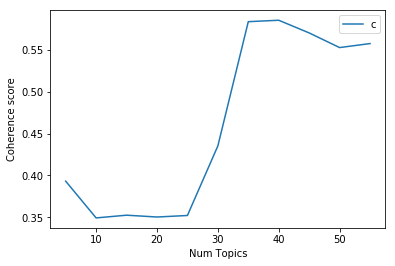

In [17]:
# Show graph
limit=60; start=5; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [18]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 5  has Coherence Value of 0.3931
Num Topics = 10  has Coherence Value of 0.3492
Num Topics = 15  has Coherence Value of 0.3524
Num Topics = 20  has Coherence Value of 0.3502
Num Topics = 25  has Coherence Value of 0.3521
Num Topics = 30  has Coherence Value of 0.4352
Num Topics = 35  has Coherence Value of 0.5836
Num Topics = 40  has Coherence Value of 0.5854
Num Topics = 45  has Coherence Value of 0.5702
Num Topics = 50  has Coherence Value of 0.5527
Num Topics = 55  has Coherence Value of 0.5575


In [23]:
# Select the model and print the topics
optimal_model = model_list[3] # here k = 20, the topics start getting repetative at k = 25 
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.236*"way" + 0.115*"fuck" + 0.098*"mean" + 0.076*"city" + 0.058*"choose" + '
  '0.049*"someone" + 0.048*"old" + 0.039*"robert" + 0.034*"new" + '
  '0.027*"hunt"'),
 (1,
  '0.181*"never" + 0.180*"thing" + 0.127*"hand" + 0.127*"ever" + 0.106*"wall" '
  '+ 0.090*"head" + 0.060*"life" + 0.038*"south" + 0.000*"not" + 0.000*"be"'),
 (2,
  '0.391*"know" + 0.258*"want" + 0.199*"father" + 0.043*"hold" + 0.028*"lie" + '
  '0.000*"not" + 0.000*"be" + 0.000*"s" + 0.000*"have" + 0.000*"make"'),
 (3,
  '0.355*"look" + 0.275*"think" + 0.131*"die" + 0.077*"ask" + 0.061*"bran" + '
  '0.000*"not" + 0.000*"be" + 0.000*"s" + 0.000*"turn" + 0.000*"walk"'),
 (4,
  '0.442*"man" + 0.184*"king" + 0.117*"run" + 0.081*"sister" + '
  '0.034*"mountain" + 0.033*"rest" + 0.007*"lion" + 0.004*"andal" + '
  '0.000*"quick" + 0.000*"not"'),
 (5,
  '0.269*"take" + 0.215*"jon" + 0.117*"love" + 0.066*"anything" + '
  '0.052*"kings_lande" + 0.048*"raven" + 0.026*"casterly_rock" + '
  '0.026*"afraid" + 0.025*"water"